In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def get_cols_inf(df):
    """
    Returns a list of column names that contain positive or negative infinity.
    """
    return df.columns[np.isinf(df.values).any(axis=0)].tolist()

def get_cols_zerostd(df):
    """
    Returns a list of column names with zero standard deviation (excluding NaNs).
    """
    nunique_non_nan = df.nunique(dropna=True)
    return nunique_non_nan[nunique_non_nan <= 1].index.tolist()

def get_nan_columns(df):
    """
    Returns a list of column names that contain NaN values.
    """
    return df.columns[df.isna().any()].tolist()

def plot_actual_vs_pred(y_train, y_test, y_pred, figsize=(15, 5)):
    """
    Plots actual train, test and predicted test values on a time series plot.
    Assumes all inputs are pandas Series with datetime index.
    """
    # Rename for clarity
    df_y_train = pd.DataFrame(y_train).reset_index().rename(columns={'label': "Train"})
    df_y_test = pd.DataFrame(y_test).reset_index().rename(columns={'label': "Test"})
    df_y_pred = pd.DataFrame(y_pred, index=y_test.index).reset_index().rename(columns={ 0: "Predicted"})
    # Create a combined DataFrame (aligns on index)
    df_plot = df_y_train.merge(df_y_test, on="timestamp", how = 'outer').merge(df_y_pred, on="timestamp", how='outer')
    # return df_plot
    # Plot
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(data=df_plot, x='timestamp', y='Train', label='Train', ax=ax)
    sns.lineplot(data=df_plot, x='timestamp', y='Test', label='Test', ax=ax)
    # sns.lineplot(data=df_plot, x='timestamp', y='Predicted', label='Predicted', ax=ax)
    ax.axvline(x=df_y_train['timestamp'].iloc[-1], color='gray', linestyle='--', label='Train/Test Split')
    ax.set_xlabel("Timestamp")
    ax.set_title("Actual vs Predicted Time Series")
    ax.set_ylabel("Value")
    ax.legend(loc="best")
    plt.show()

# Tree Models 3 - Random Forest: Feature Filtering and Optimization

- Filter Features first based on random forest

# Functions

## Preprocessing / Feature Engineering

In [2]:
def preprocess_train(train, columns_to_drop=[]):
    df = train.copy()
    
    #### Preprocessing
    # Identify once at the start
    cols_inf = get_cols_inf(df)
    print("Columns with infinite values:", cols_inf)
    cols_nan = get_nan_columns(df)
    print("Columns with NaN values:", cols_nan)
    cols_zerostd = get_cols_zerostd(df)
    print("Columns with zero standard deviation:", cols_zerostd)
    # Drop all at once
    cols_to_drop = set(cols_inf) | set(cols_nan) | set(cols_zerostd)

    df = df.drop(columns=cols_to_drop)

    #### Feature Engineering

    df.loc[:, 'bidask_ratio'] = df['bid_qty'] / df['ask_qty']
    df.loc[:, 'buysell_ratio'] = np.where(df['volume'] == 0, 0, df['buy_qty'] / df['sell_qty'])
    df.loc[:, 'liqnorm_buysellratio'] = np.where(df['volume'] == 0, 0, (df['buy_qty'] + df['sell_qty']) / df['volume'] )
    df.loc[:, 'orderflow_imbalance'] = np.where(df['volume'] == 0, 0, (df['buy_qty'] - df['sell_qty']) / (df['buy_qty'] + df['sell_qty']))

    # df.loc[:, 'buysell_ratio_shift1'] = df['buysell_ratio'].shift(-1)

    df.loc[:, 'bidask_delta'] = df['bid_qty'] - df['ask_qty']
    df.loc[:, 'buysell_delta'] = df['buy_qty'] - df['sell_qty']

    df.loc[:, 'buysell_size'] = df['buy_qty'] + df['sell_qty']
    df.loc[:, 'bidask_size'] = df['bid_qty'] + df['ask_qty']


    # Final Drop
    df = df.drop(columns=columns_to_drop)
    df = df.sort_index(ascending=True)
    return df

## Data Splitting

1. `sklearn_timeseries_split` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html))
   1. expanding window, rolling forward
2. `sklearn_traintest_split`
   1. fixed window
3. `walkforward_split`
   1. fixed window, rolling forward

In [3]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

def sklearn_timeseries_split(X, n_splits=5, **kwargs):
    tscv = TimeSeriesSplit(n_splits=n_splits, **kwargs)
    for train_idx, test_idx in tscv.split(X):
        yield train_idx, test_idx

def sklearn_traintest_split(X, y, test_size=0.2, **kwargs):
    return train_test_split(X, y, test_size=test_size, **kwargs)

def walkforward_split(X, initial_train_size, test_size, step_size=1):
    """
    Generator for walk-forward validation splits.

    Parameters:
    - X: pandas DataFrame or Series (indexed by time)
    - initial_train_size: int, number of initial observations for training
    - test_size: int, number of observations in each test fold
    - step_size: int, how much the train/test window shifts per iteration

    Yields:
    - (train_index, test_index): tuple of numpy arrays
    """
    n = len(X)
    train_start = 0

    for train_end in range(initial_train_size, n - test_size + 1, step_size):
        test_start = train_end
        test_end = test_start + test_size

        train_index = np.arange(train_start, train_end)
        test_index = np.arange(test_start, test_end)

        yield train_index, test_index

# Data

In [4]:
data = pd.read_parquet('kaggle/data/train.parquet')
# data = pd.read_parquet("/kaggle/input/drw-crypto-market-prediction/train.parquet")
y = data['label']
X = preprocess_train(data, columns_to_drop=['label', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty'])
X

Columns with infinite values: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717']
Columns with NaN values: []
Columns with zero standard deviation: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872']


,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,0.027359,0.035780,0.068219,1.034825,...,0.159183,0.530636,1.814006,3.921505,1.0,0.593620,6.858,131.421,221.389,23.708
2023-03-01 00:01:00,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,...,0.158963,0.530269,16.519692,1.633316,1.0,0.240501,36.254,203.896,847.796,40.926
2023-03-01 00:02:00,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,...,0.158744,0.529901,0.007336,1.167619,1.0,0.077329,-59.808,22.858,295.596,60.692
2023-03-01 00:03:00,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,...,0.158524,0.529534,0.231490,2.686731,1.0,0.457514,-16.151,210.779,460.705,25.881
2023-03-01 00:04:00,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,...,0.158304,0.529167,7.869603,2.216115,1.0,0.378132,23.707,54.004,142.818,30.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:55:00,94.388,0.020155,0.076565,0.228994,0.288856,0.151634,0.108347,0.088073,0.073729,0.071211,...,0.136494,0.243172,0.611756,0.705263,1.0,-0.172840,-2.642,-16.314,94.388,10.968
2024-02-29 23:56:00,177.372,0.016262,0.062527,0.214072,0.276463,0.146521,0.104164,0.084063,0.069788,0.024066,...,0.136305,0.243004,0.564317,1.640604,1.0,0.242597,-1.768,43.030,177.372,6.348
2024-02-29 23:57:00,101.252,0.045407,0.109834,0.263577,0.329266,0.174214,0.132940,0.113052,0.098865,-0.057370,...,0.136117,0.242836,1.438736,2.292427,1.0,0.392545,1.597,39.746,101.252,8.877


# Model Training

## 1 Data Split

In [5]:
X_train, X_test, y_train, y_test = sklearn_traintest_split(X, y, test_size=0.3, shuffle=False)
X_train

,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,0.027359,0.035780,0.068219,1.034825,...,0.159183,0.530636,1.814006,3.921505,1.0,0.593620,6.858,131.421,221.389,23.708
2023-03-01 00:01:00,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,...,0.158963,0.530269,16.519692,1.633316,1.0,0.240501,36.254,203.896,847.796,40.926
2023-03-01 00:02:00,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,...,0.158744,0.529901,0.007336,1.167619,1.0,0.077329,-59.808,22.858,295.596,60.692
2023-03-01 00:03:00,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,...,0.158524,0.529534,0.231490,2.686731,1.0,0.457514,-16.151,210.779,460.705,25.881
2023-03-01 00:04:00,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,...,0.158304,0.529167,7.869603,2.216115,1.0,0.378132,23.707,54.004,142.818,30.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12 05:25:00,42.613,-0.316648,0.096335,0.177395,0.094867,-0.032564,-0.240218,-0.338348,-0.372513,-0.248211,...,1.469788,2.338208,1.211526,0.184945,1.0,-0.687842,2.705,-29.311,42.613,28.281
2023-11-12 05:26:00,25.050,-0.246827,0.214523,0.306808,0.230663,0.036948,-0.169926,-0.268156,-0.302483,-0.228369,...,1.469946,2.338784,26.653924,1.087326,1.0,0.041836,12.750,1.048,25.050,13.744
2023-11-12 05:27:00,34.009,-0.301947,0.094804,0.190229,0.118450,-0.018021,-0.224422,-0.322827,-0.357354,-0.267332,...,1.470105,2.339359,2.535714,5.058970,1.0,0.669911,5.246,22.783,34.009,12.078


## 2 Model: Random Forest

$$
\hat f(x) = \frac{1}{M}\sum_{m=1}^M f_m(x),
$$

Each tree $f_m$ is fitted on a bootstrap sample of size $n$ drawn with replacement from the full training set $\{(x_i,y_i)\}_{i=1}^n$. 

Approximately $n/e$ observations remain out‐of‐bag (OOB), permitting an internal estimate of generalization error without a separate validation set. 

At each node, exactly $d = \texttt{max\_features}$ out of the total $p$ features are considered for splitting. 

Common defaults are $d = \sqrt{p}$ for classification or $d = p/3$ for regression. Because each tree sees a different subset of samples and features, the average correlation $\rho$ between any two trees is reduced. 

For regression, if each tree has variance $\sigma^2$ and pairwise correlation $\rho$, then the ensemble variance is

$$
\mathrm{Var}[\hat f(x)] = \rho\,\sigma^2 + \frac{1-\rho}{M}\,\sigma^2.
$$

A single decision tree partitions feature space by recursively choosing splits that minimize impurity. For regression, the impurity measure at node $t$ is

$$
\mathrm{MSE}(t) = \frac{1}{|t|}\sum_{(x_i,y_i)\in t} \bigl(y_i - \bar y_t\bigr)^2,\quad \bar y_t = \frac{1}{|t|}\sum_{(x_i,y_i)\in t} y_i,
$$

and each split $(j,s)$ minimizes

$$
|t_L|\;\mathrm{MSE}(t_L)\;+\;|t_R|\;\mathrm{MSE}(t_R),
$$

where $t_L = \{(x_i,y_i)\in t: x_{i,j} \le s\}$ and $t_R$ is its complement. Random Forest repeats this across bootstrap replicates and averages or votes to form the final predictor.

### Hyperparameters

The primary hyperparameters divide into tree‐level and ensemble‐level settings. 


- `max_depth` ($D_{\max}$) - Setting `max_depth=None` allows trees to grow until leaves are pure or contain fewer than `min_samples_split` observations. Deeper trees ($D_{\max}$ large) reduce bias but increase variance, whereas smaller $D_{\max}$ increases bias but can prevent overfitting. 
- `min_samples_split` ($s_{\min}$)
- `min_samples_leaf` ($\ell_{\min}$) - The constraint `min_samples_leaf = \ell_{\min}` forces each terminal node to have at least $\ell_{\min}$ samples, smoothing predictions and reducing variance.
- `max_leaf_nodes` ($L_{\max}$) - Limiting `max_leaf_nodes = L_{\max}` indirectly controls depth by capping the total number of leaves.
- `max_features` ($d$) - The choice of `max_features = d` determines that, at each node, exactly $d$ features are randomly selected from the $p$ to consider for splitting. Typical choices are $d = \sqrt{p}$ or $d = \log_2 p$ for classification, or $d = p/3$ for regression. Smaller $d$ reduces the correlation $\rho$ among trees, thus lowering variance at the cost of increased bias in individual trees.
- Ensemble‐level parameters include `n_estimators = M` (the number of trees), 
- `bootstrap` (whether to sample with replacement; setting `bootstrap=False` means all trees see the entire dataset, increasing correlation $\rho$), 
- `oob_score` (if `True`, uses OOB samples to estimate generalization error as

    $$
    \mathrm{OOB\_Error} = \frac{1}{n} \sum_{i=1}^n \ell\bigl(y_i,\hat f_{\mathrm{oob}}(x_i)\bigr),
    $$

    where $\hat f_{\mathrm{oob}}(x_i)$ averages only the trees that did not include $(x_i,y_i)$ in their bootstrap), and `warm_start` (if `True`, allows incremental addition of trees without discarding previously built ones).

**Bias–variance trade‐off and parameter effects:**
Increasing `n_estimators = M` reduces the term $\frac{1-\rho}{M}\,\sigma^2$; as $M$ grows, ensemble variance converges to $\rho\,\sigma^2$. Once OOB error stabilizes, further increases yield diminishing returns. Setting `max_depth = D_{\max}` to a large value (or `None`) yields nearly pure leaves (low bias) but high variance; restricting $D_{\max}$ introduces bias but can mitigate overfitting. Adjusting `min_samples_leaf = \ell_{\min}` and `min_samples_split = s_{\min}` smooths predictions by requiring more samples per node or leaf, thus reducing variance. Choosing `max_features = d` trades off bias versus variance: a smaller $d$ increases individual tree bias (since each tree sees fewer features) but reduces inter‐tree correlation $\rho$, lowering ensemble variance; a larger $d$ does the opposite. Disabling `bootstrap` increases bias slightly but can reduce variance if dataset is small, since each tree sees all $n$ samples and no OOB estimate is available.


## 4 Data and Split

In [6]:
params_data = {
    # "d1": {
    #     "start": pd.Timestamp('2023-03-01 00:00:00'),
    #     "end": pd.Timestamp('2024-02-29 23:59:00')
    # },
    # "d2": {
    #     "start": pd.Timestamp('2023-06-01 00:00:00'),
    #     "end": pd.Timestamp('2024-02-29 23:59:00')
    # },
    "d3": {
        "start": pd.Timestamp('2023-09-01 00:00:00'),
        "end":   pd.Timestamp('2024-02-29 23:59:00')
    },
    "d4": {
        "start": pd.Timestamp('2023-12-01 00:00:00'),
        "end":   pd.Timestamp('2024-02-29 23:59:00')
    }
}

params_split = {
    "ts1": {
        "splitter_func": sklearn_timeseries_split,
        "splitter_args": {"n_splits": 5}
    },
    # "ts2": {
    #     "splitter_func": sklearn_timeseries_split,
    #     "splitter_args": {"n_splits": 10}
    # },
    # "wf1": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 500,
    #         "test_size": 100,
    #         "step_size": 100
    #     }
    # },
    # "wf2": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 1000,
    #         "test_size": 200,
    #         "step_size": 200
    #     }
    # }
}

In [7]:
# # Data 1
# start = pd.Timestamp('2023-03-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# # Data 2
# start = pd.Timestamp('2023-06-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# # Data 3
# start = pd.Timestamp('2023-09-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# Data 4
start = pd.Timestamp('2023-12-01 00:00:00')
end = pd.Timestamp('2024-02-29 23:59:00')

# Data 4
start = pd.Timestamp('2024-02-01 00:00:00')
end = pd.Timestamp('2024-02-29 23:59:00')

X_period = X[(X.index >= start) & (X.index <= end)]
y_period = y[(X.index >= start) & (X.index <= end)]
X_period.shape

(41737, 872)

## 5 Models

### 5.0 Scorer

**Summary:** In scikit-learn, the `scoring` parameter may be set to any key in `sklearn.metrics.SCORERS` (a registry of built-in scorer objects) or to a user-defined callable. For **regression**, common built-in options include:

* **`r2`**: coefficient of determination

  $$
    R^2 \;=\; 1 \;-\; \frac{\sum_{i=1}^n (y_i - \hat y_i)^2}{\sum_{i=1}^n (y_i - \bar y)^2}.
  $$
* **`neg_mean_squared_error`**: negative mean squared error (MSE)

  $$
    \text{MSE} \;=\; \frac{1}{n}\sum_{i=1}^n (y_i - \hat y_i)^2,\quad 
    \text{scorer} = -\,\text{MSE}.
  $$
* **`neg_mean_absolute_error`**: negative mean absolute error (MAE)

  $$
    \text{MAE} \;=\; \frac{1}{n}\sum_{i=1}^n \lvert y_i - \hat y_i\rvert,\quad 
    \text{scorer} = -\,\text{MAE}.
  $$
* **`neg_root_mean_squared_error`**: negative $\sqrt{\text{MSE}}$; returned as $-\sqrt{\frac{1}{n}\sum (y_i - \hat y_i)^2}$.
* **`neg_median_absolute_error`**: negative median absolute error.
* **`explained_variance`**:

  $$
    \text{EV} \;=\; 1 \;-\; \frac{\mathrm{Var}(y - \hat y)}{\mathrm{Var}(y)}.
  $$
* Specialized deviances (e.g.\ `neg_mean_poisson_deviance`, `neg_mean_gamma_deviance`).

Note that any loss‐type metric appears as its negative (prefixed by `neg_`) because cross‐validation routines **maximize** the scorer. Thus choosing `scoring='neg_mean_squared_error'` drives BayesSearchCV to minimize the true MSE.

For **classification**, built-in scorers include (but are not limited to):

* **`accuracy`**:

  $$
    \text{Accuracy} \;=\; \frac{1}{n}\sum_{i=1}^n \mathbf{1}(\hat y_i = y_i).
  $$
* **`precision`**, **`recall`**, **`f1`**:

  $$
    \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}},\quad
    \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}},\quad
    F_1 = 2\,\frac{\text{Precision}\,\text{Recall}}{\text{Precision} + \text{Recall}}.
  $$
* **`roc_auc`**: area under the ROC curve (requires `predict_proba` or `decision_function`);

  $$
    \mathrm{AUC} \;=\; \int_0^1 \mathrm{TPR}\bigl(\mathrm{FPR}^{-1}(t)\bigr)\,dt.
  $$
* **`log_loss`**: negative log‐likelihood (cross‐entropy), returned as its negative:

  $$
    \text{LogLoss} \;=\; -\frac{1}{n}\sum_{i=1}^n \sum_{c=1}^C \mathbf{1}(y_i = c)\,\log \hat p_{i,c}.
  $$
* **`average_precision`**, **`balanced_accuracy`**, **`roc_auc_ovr`**, **`roc_auc_ovo`**, **`matthews_corrcoef`**, **`cohen_kappa`**, **`jaccard`**, etc.

The Pearson correlation coefficient between $\{y_i\}$ and $\{\hat y_i\}$ is

$$
\rho = \frac{\sum_{i=1}^n (y_i - \bar y)\,(\hat y_i - \overline{\hat y})}{\sqrt{\sum_{i=1}^n (y_i - \bar y)^2}\,\sqrt{\sum_{i=1}^n (\hat y_i - \overline{\hat y})^2}}.
$$

Then pass `scoring=pearson_scorer` into your `BayesSearchCV` (or `GridSearchCV`). This ensures that hyperparameters are selected to **maximize** the Pearson correlation between predictions and true targets.


In [8]:
from sklearn.metrics import make_scorer

def pearson_corr(estimator, X, y_true):
    y_pred = estimator.predict(X)
    # Compute means
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    # Numerator: covariance
    num = np.sum((y_true - y_true_mean) * (y_pred - y_pred_mean))
    # Denominator: product of standard deviations
    den = np.sqrt(np.sum((y_true - y_true_mean)**2) * np.sum((y_pred - y_pred_mean)**2))
    return num / den

pearson_scorer = make_scorer(pearson_corr, greater_is_better=True)

### 5.1 RandomForestRegressor

<!-- Let $\theta = (\theta_1,\dots,\theta_k)$ denote hyperparameters, such as $\theta_1 = M$, $\theta_2 = D_{\max}$, $\theta_3 = d$, $\theta_4 = \ell_{\min}$, etc. Define the validation loss (for example, cross‐validated MSE) as

$$
L(\theta) = \frac{1}{K} \sum_{j=1}^K \frac{1}{n_j} \sum_{(x_i,y_i)\in \mathcal{V}_j} \bigl(y_i - \hat f^{(j)}(x_i; \theta)\bigr)^2,
$$

where $\{\mathcal{V}_j\}_{j=1}^K$ are the $K$ folds, $n_j = |\mathcal{V}_j|$, and $\hat f^{(j)}(\cdot; \theta)$ is the RF trained on the other $K-1$ folds using hyperparameters $\theta$. We seek

$$
\theta^* = \arg\min_{\theta} L(\theta),
$$

but each evaluation of $L(\theta)$ requires training $K$ trees sets, which is expensive. 

Bayesian optimization addresses this by fitting a Gaussian Process (GP) surrogate model over $\theta$. Assume

$$
L(\theta) \sim \mathcal{GP}\bigl(m(\theta),\,k(\theta,\theta')\bigr),
$$

where $m(\theta)$ is the prior mean (often set to zero) and $k(\theta,\theta')$ is a covariance kernel (e.g.\ Matérn or RBF). Given $t$ observed pairs $\{(\theta^{(i)}, L^{(i)})\}$, the GP posterior for any new $\theta$ is

$$
L(\theta) \,\bigl|\{\theta^{(i)},L^{(i)}\}\sim \mathcal{N}\bigl(\mu_t(\theta),\,\sigma_t^2(\theta)\bigr),
$$

where

$$
\mu_t(\theta) = k(\theta)^\top K^{-1} \mathbf{L},\quad
\sigma_t^2(\theta) = k(\theta,\theta) - k(\theta)^\top K^{-1} k(\theta),
$$

with $K_{ij} = k(\theta^{(i)}, \theta^{(j)})$, $k(\theta) = \bigl[k(\theta,\theta^{(1)}),\dots,k(\theta,\theta^{(t)})\bigr]^\top$, and $\mathbf{L} = [L^{(1)},\dots,L^{(t)}]^\top$. 

An acquisition function $a_t(\theta)$, such as Expected Improvement (EI) over the best observed loss $L_{\min} = \min_i L^{(i)}$, is defined by

$$
a_t(\theta) = \mathbb{E}\bigl[\max\{0,\,L_{\min} - L(\theta)\}\bigr]
= \bigl(L_{\min}-\mu_t(\theta)\bigr)\,\Phi\bigl(z(\theta)\bigr) + \sigma_t(\theta)\,\varphi\bigl(z(\theta)\bigr),
$$

where

$$
z(\theta) = \frac{L_{\min} - \mu_t(\theta)}{\sigma_t(\theta)},\quad
\Phi(z) = \int_{-\infty}^z \frac{1}{\sqrt{2\pi}} e^{-u^2/2}\,du,\quad
\varphi(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2/2}.
$$

At iteration $t+1$, one selects

$$
\theta^{(t+1)} = \arg\max_{\theta} a_t(\theta),
$$

then evaluates $L(\theta^{(t+1)})$, updates the GP posterior, and repeats until a stopping criterion (e.g.\ a fixed number of iterations) is met. -->

In [9]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.metrics import mean_squared_error

# 3. Define the base estimator and the search space
base_rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_space = {
    'n_estimators':    Integer(50, 500),
    'max_depth':       Integer(5, 50),
    'min_samples_leaf': Integer(1, 10),
    'max_features':    Categorical(['sqrt', 'log2', 0.1, 0.3, 0.5, 1.0]),
    # Replace 'mse' → 'squared_error'; 'mae' → 'absolute_error'
    'criterion':       Categorical(['squared_error', 'absolute_error'])
}

### 5.2 XGBoost 

In [ ]:
from xgboost import XGBRegressor

# base_xgb = XGBRegressor(random_state=42, n_jobs=-1)
base_xgb = XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    random_state=42,
)

xgb_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'gamma': Real(0, 5)
}

### 5.3 LightGBM

In [11]:
from lightgbm import LGBMRegressor

# base_lgb = LGBMRegressor(random_state=42, n_jobs=-1)
base_lgb = LGBMRegressor(
    device='gpu',
    gpu_platform_id=0,   # usually 0 if you have a single GPU
    gpu_device_id=0,
    random_state=42,
)

lgb_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'num_leaves': Integer(20, 150),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(0, 5),
    'reg_lambda': Real(0, 5)
}
# opt_lgb = BayesSearchCV(base_lgb, lgb_space, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
# opt_lgb.fit(X_train, y_train)

### 5.4 CatBoost

In [12]:
from catboost import CatBoostRegressor

# base_cat = CatBoostRegressor(random_state=42, verbose=0)
base_cat = CatBoostRegressor(
    task_type='GPU',
    devices='0',        # which GPU; use ‘0’ if you have a single GPU
    random_state=42,
    verbose=0,
)

cat_space = {
    'iterations': Integer(50, 500),
    'depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'l2_leaf_reg': Real(1, 10),
    'bagging_temperature': Real(0, 1)
}
# opt_cat = BayesSearchCV(base_cat, cat_space, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
# opt_cat.fit(X_train, y_train)

### 5.5 GradientBoostingRegressor

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

base_gb = GradientBoostingRegressor(random_state=42)
gb_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'min_samples_leaf': Integer(1, 10)
}
# opt_gb = BayesSearchCV(base_gb, gb_space, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
# opt_gb.fit(X_train, y_train)

## 6 Training

In [14]:
X_train, X_test, y_train, y_test = sklearn_traintest_split(X=X_period, y=y_period, test_size=0.3, shuffle=False)
X_train

,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-02-01 00:00:00,94.421,0.115107,0.474843,0.569143,0.525292,0.186077,0.117180,0.100912,0.111818,0.378102,...,0.138154,0.319480,1.055678,0.820725,1.0,-0.098463,0.202,-9.297,94.421,7.458
2024-02-01 00:01:00,516.998,-0.110973,0.020622,0.113210,0.071934,-0.039672,-0.108598,-0.124994,-0.114182,-0.090815,...,0.137963,0.319259,24.410053,4.165589,1.0,0.612822,8.849,316.828,516.998,9.605
2024-02-01 00:02:00,161.796,-0.117109,0.007591,0.097682,0.058684,-0.045429,-0.114416,-0.130948,-0.120235,-0.146696,...,0.137772,0.319038,17.239506,1.142000,1.0,0.066293,6.577,10.726,161.796,7.387
2024-02-01 00:03:00,296.458,-0.289486,-0.306512,-0.239102,-0.281380,-0.216006,-0.285998,-0.302904,-0.292408,-0.160262,...,0.137582,0.318817,0.175398,2.300983,1.0,0.394120,-2.849,116.840,296.458,4.061
2024-02-01 00:04:00,116.111,-0.203522,-0.122349,-0.065007,-0.107658,-0.128967,-0.199480,-0.216639,-0.206301,0.155547,...,0.137391,0.318596,0.177089,0.474706,1.0,-0.356202,-5.948,-41.359,116.111,8.508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-21 07:12:00,246.328,0.433092,-1.333297,-1.368820,-1.175475,-0.406817,0.054442,0.269666,0.358804,0.584759,...,0.107594,0.478685,1.932480,2.888243,1.0,0.485629,3.425,119.624,246.328,10.771
2024-02-21 07:13:00,125.318,0.502460,-1.085964,-1.190404,-1.019743,-0.334661,0.123468,0.338564,0.427875,0.595196,...,0.107445,0.478353,2.113905,1.102087,1.0,0.048564,2.171,6.086,125.318,6.069
2024-02-21 07:14:00,130.303,0.466361,-1.052875,-1.221873,-1.074040,-0.367695,0.087127,0.302045,0.391505,0.579696,...,0.107299,0.478023,2.394570,1.902718,1.0,0.310991,4.623,40.523,130.303,11.253


In [ ]:
# 4. Set up BayesSearchCV
#    We use 5‐fold CV to estimate validation error L(θ) = (1/5) ∑_j MSE_j
# opt_rf = BayesSearchCV(
#     estimator=base_rf,
#     search_spaces=param_space,
#     n_iter=50,                  # number of Bayesian optimization iterations
#     cv=5,                       # 5‐fold cross‐validation on trainval
#     scoring='neg_mean_squared_error',
#     random_state=42,
#     n_jobs=-1,
#     verbose=0
# )

# 5. Execute the search
#    This will sequentially propose hyperparameter vectors θ^(t),
#    fit 5 RF models for each θ^(t), compute the CV‐MSE, update the GP surrogate,
#    and repeat for 50 iterations.
# opt_rf.fit(X_train, y_train)

# 6. Retrieve the best hyperparameters and refit on full trainval
# best_params = opt_rf.best_params_
# best_rf = RandomForestRegressor(
#     **best_params,
#     random_state=42,
#     n_jobs=-1
# )
# best_rf.fit(X_train, y_train)

# # 7. Evaluate on the held‐out test set
# y_pred = best_rf.predict(X_test)

# # Results
# test_mse = mean_squared_error(y_test, y_pred)
# print("Best hyperparameters:", best_params)
# print(f"Test MSE: {test_mse:.4f}")

# test_corr = pearson_corr(best_rf, X_test, y_test)
# print(f"Test Pearson Correlation: {test_corr:.4f}")

from scipy.stats import pearsonr

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on the test set and prints the results.
    """
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_corr = pearsonr(y_test, y_pred)[0]
    
    print(f"""
    Model: {model.__class__.__name__}
    Best Hyperparameters: {model.get_params()}
    """)
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test Pearson Correlation: {test_corr:.4f}")
    
    return y_pred

# opt_xgb = BayesSearchCV(base_xgb, xgb_space, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
# opt_xgb.fit(X_train, y_train)
# opt_xgb_bestparams = opt_xgb.best_params_
# print(opt_xgb_bestparams)

opt_lgb = BayesSearchCV(base_lgb, lgb_space, n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
opt_lgb.fit(X_train, y_train)
opt_lgb_bestparams = opt_lgb.best_params_
print(opt_lgb_bestparams)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:50:21] WARNING: /Users/runner/work/xgboost/xgboost/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/pytho

XGBoostError: [10:50:21] /Users/runner/work/xgboost/xgboost/src/gbm/../common/common.h:181: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011f8059e0 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000011f9e837c xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>>> const&) + 1280
  [bt] (2) 3   libxgboost.dylib                    0x000000011fa07e18 xgboost::LearnerConfiguration::Configure() + 1272
  [bt] (3) 4   libxgboost.dylib                    0x000000011fa08068 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x000000011f82856c XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.dylib                        0x000000019d1ac050 ffi_call_SYSV + 80
  [bt] (6) 7   libffi.dylib                        0x000000019d1b4af0 ffi_call_int + 1220
  [bt] (7) 8   _ctypes.cpython-312-darwin.so       0x000000010478b3b8 _ctypes_callproc + 1384
  [bt] (8) 9   _ctypes.cpython-312-darwin.so       0x00000001047832a0 PyCFuncPtr_call + 212



In [ ]:
best_xgb = XGBRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)
best_xgb.fit(X_train, y_train)

model = best_xgb
y_pred = evaluate_model(model, X_test, y_test)
plot_actual_vs_pred(y_train, y_test, y_pred=y_pred)

# Best Model

In [ ]:
# importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
# importances

X302           0.020218
X465           0.018622
X466           0.014421
X464           0.014392
X753           0.012193
                 ...   
X504           0.000000
X775           0.000000
X501           0.000000
X500           0.000000
bidask_size    0.000000
Length: 872, dtype: float64

# Feature Importance

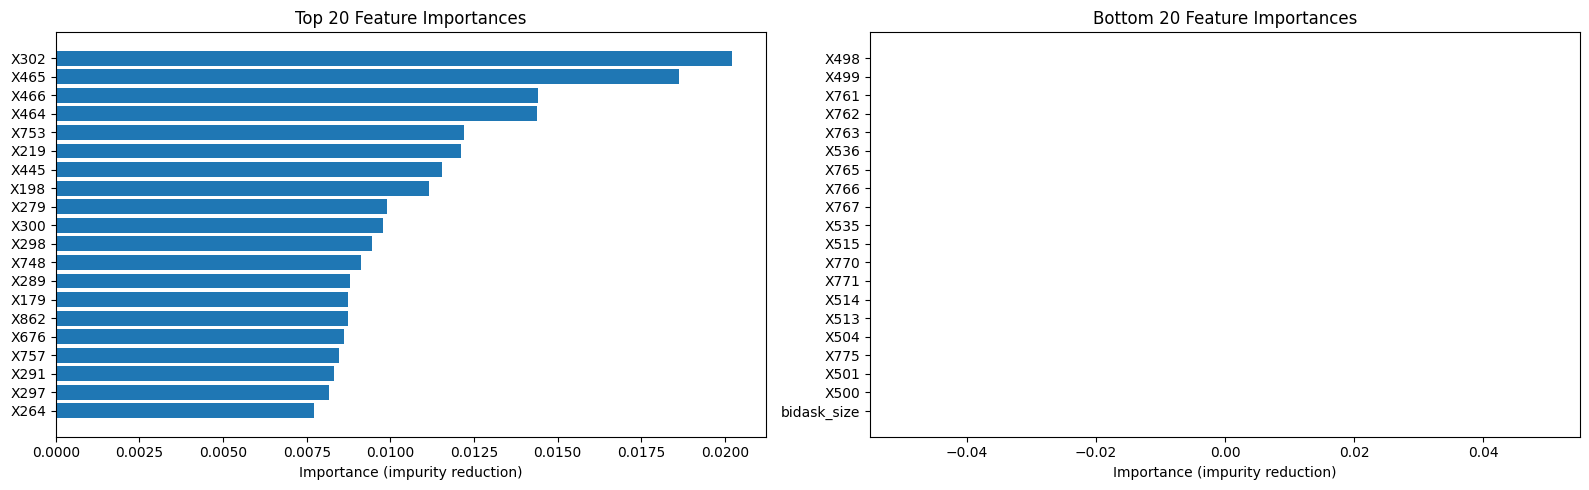

In [ ]:
import matplotlib.pyplot as plt

def plot_treebased_importance(
    model: RandomForestRegressor,
    columns: list[str],
    count: int = 10,
    figsize: tuple[int, int] = (16, 10)
) -> None:
    """
    Plot the top `n_features` and bottom `n_features` feature importances 
    from a fitted RandomForestRegressor.

    Parameters
    ----------
    model : RandomForestRegressor
        A fitted RandomForestRegressor instance.
    columns : list[str]
        List of feature names (must match the order used to fit `model`).
    n_features : int, default 10
        Number of top and bottom features to plot.
    figsize : tuple[int, int], default (16, 10)
        Figure size for the combined 1×2 plot.
    """
    # 1. Build a Series of importances, indexed by feature name, sorted descending
    importances = pd.Series(
        data=model.feature_importances_,
        index=columns
    ).sort_values(ascending=False)

    # 2. Select top-n (highest importance) and bottom-n (lowest importance)
    top_n = importances.head(count)
    bottom_n = importances.tail(count)

    # 3. Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 4. Plot top-n (left); invert y-axis so highest importance appears at top
    axes[0].barh(top_n.index, top_n.values)
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {count} Feature Importances")
    axes[0].set_xlabel("Importance (impurity reduction)")

    # 5. Plot bottom-n (right); invert y-axis so lowest importance appears at top
    axes[1].barh(bottom_n.index, bottom_n.values)
    axes[1].invert_yaxis()
    axes[1].set_title(f"Bottom {count} Feature Importances")
    axes[1].set_xlabel("Importance (impurity reduction)")

    plt.tight_layout()
    plt.show()
    return importances

# importances = plot_treebased_importance(model=rf, columns=X.columns, count=20, figsize=(16, 5))

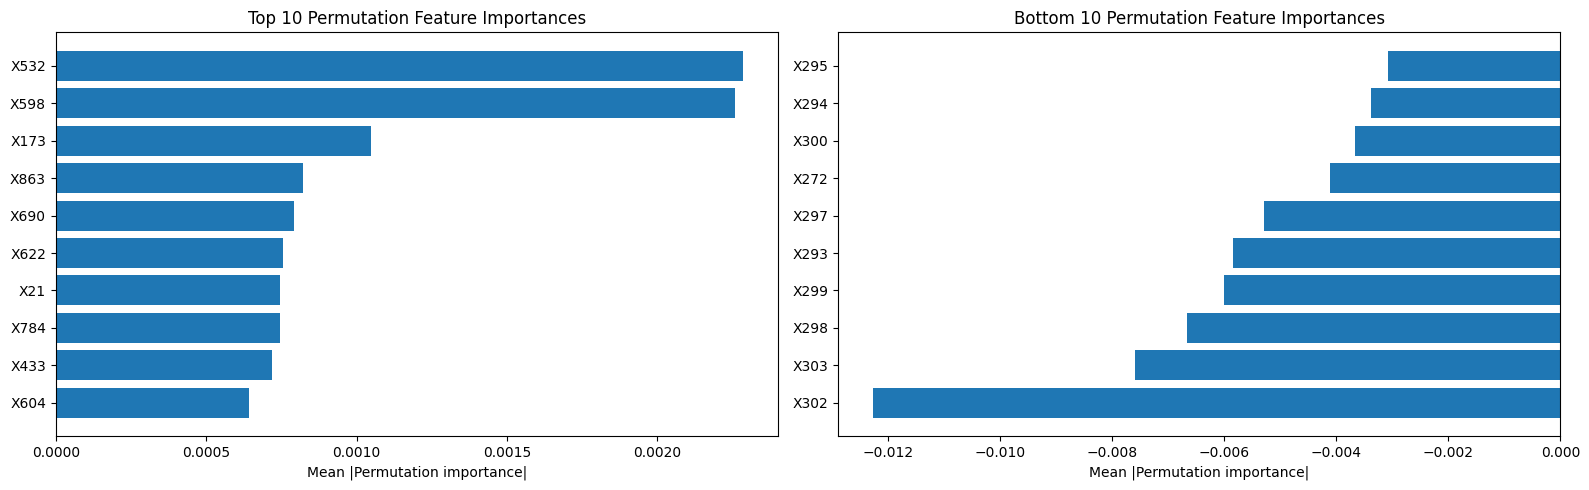

In [ ]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(
    model: RandomForestRegressor,
    X_test: pd.DataFrame,
    y_test: pd.Series | np.ndarray,
    random_state: int | None = None,
    count: int = 10,
    n_repeats: int = 5,
    n_jobs: int = -1,
    scoring: str = 'neg_mean_squared_error',
    figsize: tuple[int, int] = (8, 6)
) -> None:
    """
    Compute permutation importances on a fitted RandomForestRegressor quickly 
    by using parallel jobs and fewer repeats, then plot a descending bar chart of mean importance.

    Parameters
    ----------
    model : RandomForestRegressor
        A fitted RandomForestRegressor instance.
    X_test : pd.DataFrame
        Feature matrix for testing.
    y_test : pd.Series or np.ndarray
        True target values corresponding to X_test.
    random_state : int or None, default=None
        Seed for reproducibility (used by permutation_importance).
    n_repeats : int, default=5
        Number of times to permute a feature. Fewer repeats speeds up computation.
    n_jobs : int, default=-1
        Number of parallel jobs for permutation_importance. Set to -1 to use all available cores.
    scoring : str, default='neg_mean_squared_error'
        Scoring metric to evaluate performance after permutation.
    figsize : tuple[int, int], default=(8, 6)
        Figure size for the bar chart.
    """
    # Optionally subsample X_test if it's very large (uncomment if needed)
    # max_samples = 1000
    # if len(X_test) > max_samples:
    #     X_sub = X_test.sample(n=max_samples, random_state=random_state)
    #     y_sub = y_test[X_sub.index]
    # else:
    #     X_sub, y_sub = X_test, y_test

    # Compute permutation importances using parallel jobs
    perm_res = permutation_importance(
        estimator=model,
        X=X_test,
        y=y_test,
        n_repeats=n_repeats,
        random_state=random_state,
        scoring=scoring,
        n_jobs=n_jobs
    )

    importances_mean = pd.Series(perm_res.importances_mean, index=X_test.columns).sort_values(ascending=False)

    # 3. Select top‐`count` and bottom‐`count`
    top_n = importances_mean.head(count)
    bottom_n = importances_mean.tail(count)

    # 4. Create a 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 5. Plot top‐count features on the left (highest at top)
    axes[0].barh(top_n.index, top_n.values)
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {count} Permutation Feature Importances")
    axes[0].set_xlabel("Mean |Permutation importance|")

    # 6. Plot bottom‐count features on the right (lowest at top)
    axes[1].barh(bottom_n.index, bottom_n.values)
    axes[1].invert_yaxis()
    axes[1].set_title(f"Bottom {count} Permutation Feature Importances")
    axes[1].set_xlabel("Mean |Permutation importance|")

    plt.tight_layout()
    plt.show()
    return importances_mean

# permutation_importances = plot_permutation_importance(
#     model=rf,
#     X_test=X_test,
#     y_test=y_test,
#     random_state=42,
#     count=10,
#     n_repeats=5,
#     n_jobs=-1,
#     scoring='neg_mean_squared_error',
#     figsize=(16, 5)
# )

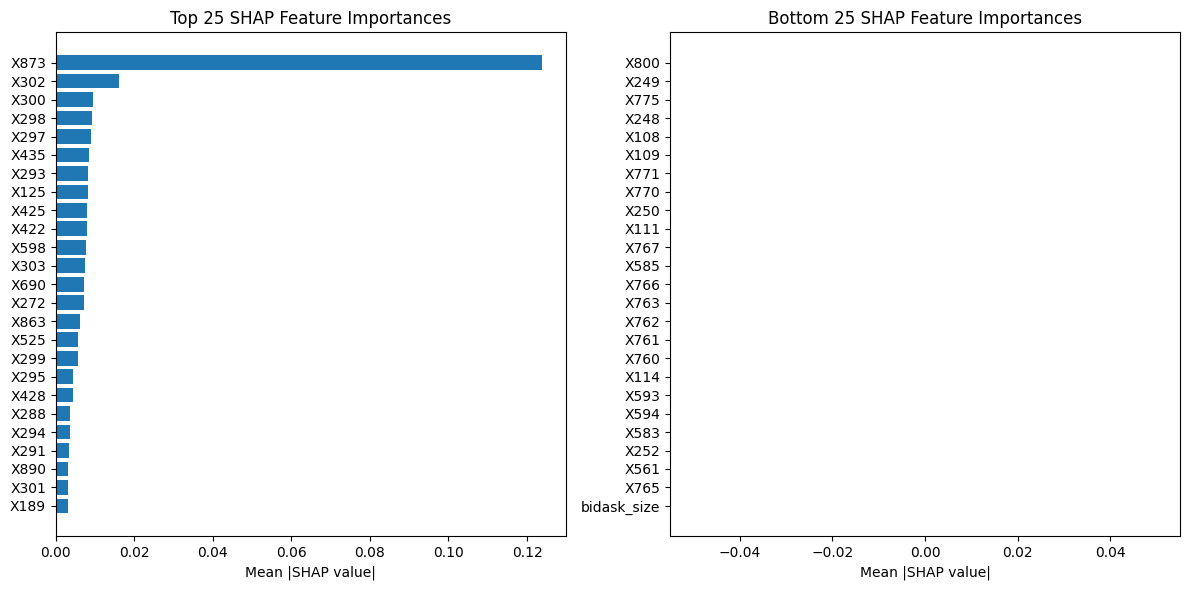

In [ ]:
import shap

def plot_shap_importance(
    X_test: pd.DataFrame,
    model,
    figsize: tuple[int, int] = (12, 6),
    count: int = 10,
) -> None:
    """
    Given a fitted tree‐based model and a test DataFrame X_test, compute TreeSHAP values 
    and plot the top `count` and bottom `count` features by average absolute SHAP value.

    Parameters
    ----------
    X_test : pd.DataFrame
        Test feature matrix (no labels needed for SHAP).
    model : fitted tree‐based estimator
        A fitted model that supports TreeExplainer (e.g., RandomForestRegressor).
    figsize : tuple[int, int], default (12, 6)
        Figure size for the 1×2 plot.
    count : int, default 10
        Number of top and bottom features to display.
    """
    # 1. Compute SHAP values for X_test
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_test)  # shape: (n_test, n_features)

    # 2. Compute mean absolute SHAP value per feature
    mean_abs_shap = pd.Series(
        data=abs(shap_vals).mean(axis=0),
        index=X_test.columns
    ).sort_values(ascending=False)

    # 3. Select top‐`count` and bottom‐`count`
    top_n = mean_abs_shap.head(count)
    bottom_n = mean_abs_shap.tail(count).sort_values(ascending=True)

    # 4. Create a 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 5. Plot top‐count features on the left (highest at top)
    axes[0].barh(top_n.index, top_n.values)
    axes[0].invert_yaxis()
    axes[0].set_title(f"Top {count} SHAP Feature Importances")
    axes[0].set_xlabel("Mean |SHAP value|")

    # 6. Plot bottom‐count features on the right (lowest at top)
    axes[1].barh(bottom_n.index, bottom_n.values)
    axes[1].invert_yaxis()
    axes[1].set_title(f"Bottom {count} SHAP Feature Importances")
    axes[1].set_xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()

# shap_importance = plot_shap_importance(
#     X_test=X_test,
#     model=rf,
#     count=25
# )